# Medical AI Challenge 1: Binary Skin Lesion Segmentation

## 📝 Description
This is the first challenge in the **Medical AI Challenge Series**, designed to help participants get started with Medical AI.  
The task is to work with **dermatoscopic skin images (2D)** and build an automated system for **binary skin lesion segmentation**.

---

## 🎯 Goal
- Train a model to segment lesions from dermatoscopic images.  
- Evaluate the segmentation performance using the **Dice score**.

---

## 📊 Evaluation
- **Metric**: Dice Score (popular in medical image segmentation).  
- **Submission Rules**:
  - You can make **7 submissions per day**.  
  - The evaluation consists of two phases:
    - **Public phase**: score shown immediately after submission.  
    - **Private phase**: final leaderboard revealed after the challenge deadline.  
  - You can choose **up to 2 submissions** for the final private evaluation.  

---

## 📦 Dataset Description
The dataset consists of dermatoscopic images with corresponding binary masks.

- **Files**:
  - `Train/` → contains training images and their corresponding masks.  
  - `Test/` → contains test images for evaluation.  
  - `sample_submission.csv` → example submission file in the required format.  

- **Columns**:
  - `ID` → image ID.  
  - `Predicted_Mask` → predicted segmentation mask (RLE encoded).  

---

## 📐 Submission Format
Due to file size limits, **Run-Length Encoding (RLE)** is used for the predicted masks:  
- Pixels are **1-indexed** and counted **top-to-bottom, left-to-right**.  
- Example:
  - `"1 3"` → pixels 1, 2, 3 are part of the mask.  
  - `"1 3 10 5"` → pixels 1, 2, 3, 10, 11, 12, 13, 14 are part of the mask.  
- All test images must be **resized to (512x512)** before prediction and submission.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split, Dataset, DataLoader
from torch.amp import autocast, GradScaler

import albumentations as A

In [2]:
BASE_PATH = '/kaggle/input/warm-up-program-ai-vietnam-skin-segmentation'
TRAIN_PATH = BASE_PATH + '/Train/Train'
TEST_PATH = BASE_PATH + '/Test/Test'
BEST_MODEL_PATH = 'best_model_path.pth'

NUM_WORKERS = 4
BATCH_SIZE = 8
EPOCHS = 30
LR = 6.25e-5
PATIENCE = 5

### Data augmentation

In [3]:
train_transform = A.Compose([
    A.Resize(512, 512),
    A.RandomResizedCrop(size=(512, 512), scale=(0.7, 1)),
    A.SquareSymmetry(p=0.8),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
    A.CoarseDropout(num_holes_range=(1, 5)),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    A.ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    A.ToTensorV2()
])

### Dataset & DataLoader

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.image_path = path + '/Image/'
        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"}
        
        # TRAIN_PATH
        if self.path == TRAIN_PATH: 
            self.images = sorted([
                f for f in os.listdir(self.image_path)
                if os.path.isfile(os.path.join(self.image_path, f))
                and os.path.splitext(f)[1].lower() in valid_extensions
            ])
            self.mask_path = path + '/Mask/'
            self.masks = sorted([
                f for f in os.listdir(self.mask_path) 
                if os.path.isfile(os.path.join(self.mask_path, f)) 
                and os.path.splitext(f)[1].lower() in valid_extensions 
            ])
            
        # TEST_PATH for submission
        else:
            self.images = sorted([
            f for f in os.listdir(self.image_path)
            if os.path.isfile(os.path.join(self.image_path, f))
            and os.path.splitext(f)[1].lower() in valid_extensions
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.asarray(Image.open(self.image_path + self.images[index]).convert('RGB'))
        
        # TRAIN_PATH
        if self.path == TRAIN_PATH:
            mask = np.asarray(Image.open(self.mask_path + self.masks[index]).convert('L'))
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
        # TEST_PATH for submission
        else: 
            transformed = self.transform(image=image)
            image = transformed['image']
            mask = None

        # TRAIN_PATH -> image, mask
        image = torch.Tensor(image).to(torch.float32)
        if mask is not None: 
            mask = (torch.Tensor(mask) > 127).to(torch.float32)
            return image, mask 

        # TEST_PATH -> image
        return image

In [5]:
train_val_dataset = SegmentationDataset(TRAIN_PATH, train_transform)
test_dataset = SegmentationDataset(TEST_PATH, test_transform)

train_dataset, val_dataset, _ = random_split(train_val_dataset, [0.8, 0.1, 0.1])

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(len(train_dataset), len(val_dataset))

2076 259


### Visualization

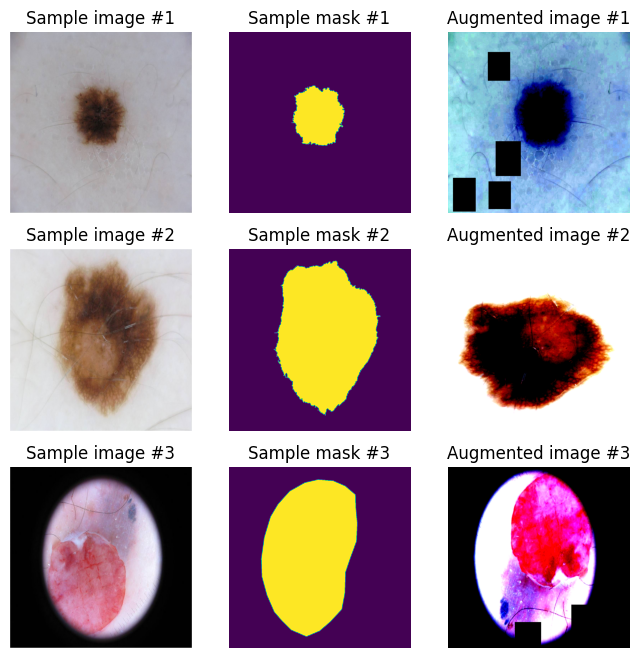

In [6]:
fig = plt.figure(figsize=(8, 8))

j = 1

images = sorted(os.listdir(TRAIN_PATH + '/Image/'))
masks = sorted(os.listdir(TRAIN_PATH + '/Mask/'))

for i in range(1, 10, 3):
    img_path = TRAIN_PATH + '/Image/' + images[j]
    mask_path = TRAIN_PATH + '/Mask/' + masks[j]
    
    img = Image.open(img_path).convert('RGB').resize((512, 512))
    mask = Image.open(mask_path).convert('L').resize((512, 512))

    ax = []

    ax.append(fig.add_subplot(3, 3, i))
    ax[-1].set_title(f'Sample image #{j}')
    plt.axis('off')
    plt.imshow(img)
    
    ax.append(fig.add_subplot(3, 3, i+1))
    ax[-1].set_title(f'Sample mask #{j}')
    plt.axis('off')
    plt.imshow(mask)

    img2 = cv2.imread(img_path)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    trans_img = train_transform(image=img2)['image']
    ax.append(fig.add_subplot(3, 3, i+2))
    ax[-1].set_title(f'Augmented image #{j}')
    plt.axis('off')
    plt.imshow(trans_img.permute(1, 2, 0))

    j += 1

plt.show()

### Model, loss, optimizer setup

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
!pip install -U segmentation-models-pytorch

In [9]:
import segmentation_models_pytorch as smp

In [10]:
model = smp.UnetPlusPlus(encoder_name='efficientnet-b4', encoder_weights='advprop', classes=1, activation='sigmoid')
model = model.to(device)

loss_function = smp.losses.DiceLoss(mode='binary', from_logits=False, eps=1e-7)
optimizer = optim.AdamW(model.parameters(), lr=LR)

# Iterations per epoch = Number of training samples ÷ MiniBatchSize
# Iterations = Iterations per epoch * Number of epochs

# scheduler = lr_scheduler.CyclicLR(optimizer, 
#                                   base_lr=0.001, 
#                                   max_lr=0.006, 
#                                   mode='triangular2', 
#                                   step_size_up=3)

In [11]:
# for name, layer in model.named_children():
#     if name == 'encoder':
#         for param in layer.parameters():
#             param.requires_grad = False  

### Training loop

In [12]:
def compute_acc(mask1, mask2):  

    # Compute accuracy between 2 masks (Dice score)
    # Input size of each mask = (512 x 512)
    # Output = [0, 1]
    
    mask1_flatten = torch.sum(mask1.flatten())
    mask2_flatten = torch.sum(mask2.flatten())
    intersection = torch.sum(mask1 * mask2)
    result = torch.clamp((2.0 * intersection / (mask1_flatten + mask2_flatten)), 0.0, 1.0).item()
    return result

def compute_acc_batch(masks1, masks2): 

    # Compute accuracy of a batch
    # Input size of each masks  = (16 x 512 x 512)
    # Output = [0, 1]
    
    result = []
    for (mask1, mask2) in zip(masks1, masks2):
        result.append(compute_acc(mask1, mask2))

    return 1.0 * sum(result) / len(result)

In [13]:
best_acc = 0.0
epoch_no_improve = 0

for epoch in range(EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    train_acc_list = []
    val_acc_list = []

    model.train()
    for index, (images, masks) in enumerate(train_data_loader):

        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        predicts = model(images)
        loss = loss_function(predicts, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc_list.append(compute_acc_batch(torch.round(predicts.squeeze()), masks))
    train_loss /= len(train_data_loader)
    train_acc = 100.0 * sum(train_acc_list) / len(train_acc_list)
    # scheduler.step()

    model.eval()
    with torch.no_grad():
        for index, (images, masks) in enumerate(val_data_loader):
            images = images.to(device)
            masks = masks.to(device)
            predicts = model(images)
            loss = loss_function(predicts, masks)

            val_loss += loss.item()
            val_acc_list.append(compute_acc_batch(torch.round(predicts.squeeze()), masks))
    val_loss /= len(val_data_loader)
    val_acc = 100.0 * sum(val_acc_list) / len(val_acc_list)

    print(f'Epoch [{epoch+1}/{EPOCHS}]:')
    print(f'train_acc: {train_acc:.4f}%')
    print(f'train_loss: {train_loss:.4f}')
    print(f'val_acc: {val_acc:.4f}%')
    print(f'val_loss: {val_loss:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        epoch_no_improve += 1
    if epoch_no_improve > PATIENCE:
        print('Early stopping!')
        break

print('Training done!')

Epoch [1/30]:
train_acc: 71.7959%
train_loss: 0.3569
val_acc: 86.8643%
val_loss: 0.2008
Epoch [2/30]:
train_acc: 84.4450%
train_loss: 0.1965
val_acc: 87.6369%
val_loss: 0.1466
Epoch [3/30]:
train_acc: 86.2753%
train_loss: 0.1551
val_acc: 87.8364%
val_loss: 0.1157
Epoch [4/30]:
train_acc: 87.4410%
train_loss: 0.1325
val_acc: 88.4873%
val_loss: 0.0992
Epoch [5/30]:
train_acc: 87.8843%
train_loss: 0.1194
val_acc: 89.3131%
val_loss: 0.0914
Epoch [6/30]:
train_acc: 89.3276%
train_loss: 0.1037
val_acc: 89.1932%
val_loss: 0.0890
Epoch [7/30]:
train_acc: 89.5173%
train_loss: 0.0964
val_acc: 88.7219%
val_loss: 0.0914
Epoch [8/30]:
train_acc: 89.9966%
train_loss: 0.0903
val_acc: 89.0810%
val_loss: 0.0866
Epoch [9/30]:
train_acc: 90.1558%
train_loss: 0.0853
val_acc: 89.2517%
val_loss: 0.0869
Epoch [10/30]:
train_acc: 89.9960%
train_loss: 0.0869
val_acc: 89.2164%
val_loss: 0.0859
Epoch [11/30]:
train_acc: 90.2841%
train_loss: 0.0840
val_acc: 90.1673%
val_loss: 0.0796
Epoch [12/30]:
train_acc: 90.6

### Evaluation and submission

In [14]:
dataset = SegmentationDataset(TRAIN_PATH, test_transform)
_, dataset = random_split(dataset, [0.9, 0.1])
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

accuracy = []

model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(data_loader):
        images = images.to(device)
        masks = masks.to(device)

        predicts = torch.round(model(images)).squeeze()

        accuracy.append(compute_acc(predicts, masks))

print(f'Model accuracy (Dice score): {(100 * sum(accuracy) / len(accuracy)):.4f}%')

Model accuracy (Dice score): 92.1152%


In [15]:
def mask2rle(mask):
    """
    mask: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [16]:
result = {'ID':[], 'Predicted_Mask':[]}
submission_images = sorted(os.listdir(TEST_PATH + '/Image/'))

model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()
with torch.no_grad():
    for i, images in enumerate(test_data_loader):
        id = submission_images[i].replace(os.path.splitext(submission_images[i])[1], '')
        id += '_segmentation'

        images = images.to(device)
        predicts = torch.round(model(images)).squeeze().to(torch.uint8).cpu().numpy()
        
        result['ID'].append(id)
        result['Predicted_Mask'].append(mask2rle(predicts))

submission = pd.DataFrame(result, columns=['ID', 'Predicted_Mask'])
submission.to_csv('/kaggle/working/submission.csv', index=False)
print('Submitting done!')

Submitting done!


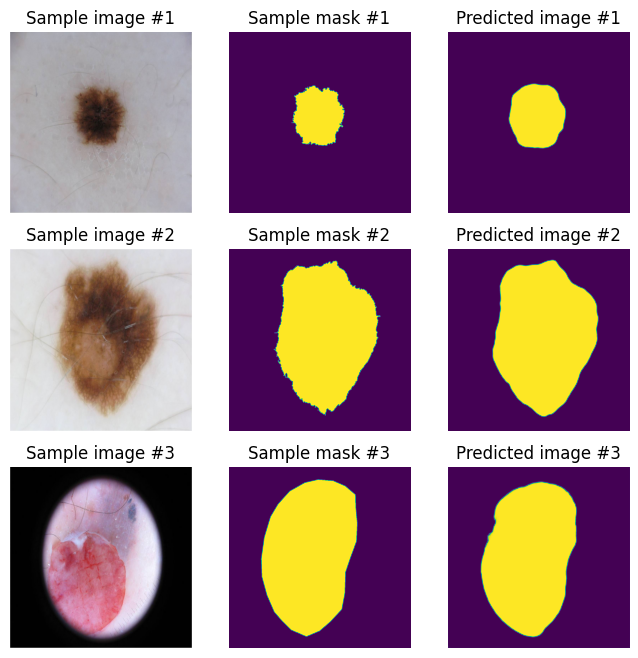

In [44]:
fig = plt.figure(figsize=(8, 8))

j = 1

images = sorted(os.listdir(TRAIN_PATH + '/Image/'))
masks = sorted(os.listdir(TRAIN_PATH + '/Mask/'))

model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()
with torch.no_grad():

    for i in range(1, 10, 3):
        img_path = TRAIN_PATH + '/Image/' + images[j]
        mask_path = TRAIN_PATH + '/Mask/' + masks[j]
        
        img = Image.open(img_path).convert('RGB').resize((512, 512))
        mask = Image.open(mask_path).convert('L').resize((512, 512))
    
        sample_img = test_transform(image=np.asarray(img))['image'].unsqueeze(0).to(device)
        
        predict = model(sample_img)
        
    
        ax = []
    
        ax.append(fig.add_subplot(3, 3, i))
        ax[-1].set_title(f'Sample image #{j}')
        plt.axis('off')
        plt.imshow(img)
        
        ax.append(fig.add_subplot(3, 3, i+1))
        ax[-1].set_title(f'Sample mask #{j}')
        plt.axis('off')
        plt.imshow(mask)
    
        img2 = cv2.imread(img_path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        ax.append(fig.add_subplot(3, 3, i+2))
        ax[-1].set_title(f'Predicted image #{j}')
        plt.axis('off')
        plt.imshow(predict.squeeze().cpu().numpy())
    
        j += 1

plt.show()